In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import skimage as sk
from skimage import transform
import random
from PIL import Image
import os
import matplotlib.pyplot as plt

from utils import train_test_split


Instructions for updating:
non-resource variables are not supported in the long term


Matplotlib is building the font cache using fc-list. This may take a moment.


In [2]:
np.mean([1.2])

1.2

In [3]:
def rotate_img(image):
    random_degree = random.uniform(-25, 25) #25% from left or right
    return sk.transform.rotate(image, random_degree)

def noise_img(image):
    return sk.util.random_noise(image)

In [4]:
with tf.Session() as sess:
    devices = sess.list_devices()
    for d in devices:
        print(d)

_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 12068069485165721096)
_DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7860899996214059432)
_DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 3159879680554869148)
_DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 7518981325, 8256987694415170389)


In [5]:
flooded_img = []
nonflooded_img = []
unlabeled_img = []

h_dim  = 1000
v_dim = 750

root = "Train"
flood_dir = os.path.join(root,'Labeled/Flooded/image/')
nonflood_dir = os.path.join(root,'Labeled/Non-Flooded/image/')
unlabel_dir = os.path.join(root,'Unlabeled/image/')

for file in os.listdir(flood_dir):
    image = Image.open(os.path.join(flood_dir, file))
    image = np.array(image.resize((h_dim,v_dim)))
    flooded_img.append(rotate_img(image))

for file in os.listdir(nonflood_dir):
    image = Image.open(os.path.join(nonflood_dir, file))
    image = np.array(image.resize((h_dim,v_dim)))
    nonflooded_img.append(rotate_img(image))
    
for file in os.listdir(unlabel_dir):
    image = Image.open(os.path.join(unlabel_dir, file))
    image = np.array(image.resize((h_dim,v_dim)))
    unlabeled_img.append(rotate_img(image))
    unlabeled_img.append(rotate_img(image))

In [6]:
print("Flooded Image Shape: {}".format(flooded_img[0].shape))
print("Non_Flooded Image Shape: {}".format(nonflooded_img[0].shape))
print("Unlabeled Image Shape: {}".format(unlabeled_img[0].shape))

Flooded Image Shape: (750, 1000, 3)
Non_Flooded Image Shape: (750, 1000, 3)
Unlabeled Image Shape: (750, 1000, 3)


In [7]:
data_img = np.vstack((np.array(flooded_img), np.array(nonflooded_img))) / 255.
data_img.shape

(397, 750, 1000, 3)

In [8]:
unlabeled_img = np.array(unlabeled_img) /255.
unlabeled_img.shape

(366, 750, 1000, 3)

In [9]:
#train_idx = np.array([np.arange(7),np.arange(10,17)]).flatten()
#test_idx = np.array([np.arange(7,10),np.arange(17,20)]).flatten()

test = False

#n is number images from each class (flooded or non flooded)
if test == True:
    n = 20
else:
    n = min(len(flooded_img),len(nonflooded_img))


idxs = train_test_split(n,flooded_img,nonflooded_img,unlabeled_img)
label_train_idx, label_test_idx, train_labels, test_labels, unlabel_train_idx, unlabel_test_idx = idxs

Training Index: [  0   1   2   5   6   7   8  10  11  12  13  15  16  17  18  19  21  22
  23  25  26  28  29  30  31  33  35  36  37  38  39  40  41  43  44  45
  47  48  49  50  64  66  87  94  96 103 107 121 136 141 154 166 181 182
 200 209 218 219 223 227 241 242 251 272 279 303 305 306 307 312 330 331
 335 351 353 354 357 366 382 384]
Testing Index: [  3   4   9  14  20  24  27  32  34  42  46  51  61 102 148 151 234 239
 258 324 356 378]
Unlabeled Training Index: [ 1  2  4  5  6  7  8  9 10 11 12 13 14 16 18 19 20 22 23 26 27 29 30 31
 32 34 35 37 38 39 40 41 42 43 44 45 46 47 48 50]


### CNN CODE

In [15]:
# convolutional layer
def conv_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[-1]]))

    out = tf.nn.conv2d(input=x, filters=weights, strides=[1,1,1,1], padding='SAME')
    out += bias
    return out

# pooling layer
def max_pool(x, k=2):

    out = tf.nn.max_pool(value=x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return out

# fully connected layer
def fully_connected_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[1]]))

    out = tf.matmul(a=x, b=weights)
    out += bias
    return out

# flatten layer
def flatten_layer(x):
    
    size = x.get_shape()[1:4].num_elements()
    out = tf.reshape(x, [-1,size])
    return out, size

# relu
relu = lambda x: tf.nn.relu(features=x)

# softmax
softmax = lambda x: tf.nn.softmax(logits=x)

# batch norm
batch_norm = lambda x: tf.layers.batch_normalization(x)

In [16]:
#shape = [filter_size, filter_size, num_input_channels, num_filters]

# define CNN
def toy_model(x):

    # Six convolutional layers with max pool and ReLU
    shape0 = [5, 5, 3, 3]
    conv0 = conv_layer(x, shape0)
    conv0 = relu(conv0)
    conv0 = batch_norm(conv0)
    conv0 = max_pool(conv0, k=2)

    shape1 = [5, 5, 3, 3]
    conv1 = conv_layer(conv0, shape1)
    conv1 = relu(conv1)
    conv1 = batch_norm(conv1)
    conv1 = max_pool(conv1, k=2)

    shape2 = [5, 5, 3, 3]
    conv2 = conv_layer(conv1, shape2)
    conv2 = relu(conv2)
    conv2 = batch_norm(conv2)
    conv2 = max_pool(conv2, k=2)

    shape3 = [5, 5, 3, 1]
    conv3 = conv_layer(conv2, shape3)
    conv3 = relu(conv3)
    conv3 = batch_norm(conv3)
    conv3 = max_pool(conv3, k=2)

    shape4 = [5, 5, 1, 1]
    conv4 = conv_layer(conv3, shape4)
    conv4 = relu(conv4)
    conv4 = batch_norm(conv4)
    conv4 = max_pool(conv4, k=2)

    shape5 = [5, 5, 1, 1]
    conv5 = conv_layer(conv4, shape5)
    conv5 = relu(conv5)
    conv5 = batch_norm(conv5)
    conv5 = max_pool(conv5, k=2)

    # flatten output and put through a fully connected layer
    flat1, size1 = flatten_layer(conv5)
    fc1 = fully_connected_layer(flat1, [size1, 64])
    fc1 = relu(fc1)

    fc2 = fully_connected_layer(fc1, [64, 1])
    out = softmax(fc2)

    return out

In [17]:
def sharpen(p):
    T = 0.5
    pred = p**(1./T)/(p**(1./T) + (1.-p)**(1./T))
    return pred

In [18]:
def generate_guess_label(pred_u_raw, k):
    # guess label = average prediction over k augmentations of same image
    # num_images = pred_u_raw.shape[0].value / k # Throws error of NoneType and int since pred_u_raw.shape[0].value is None
    
    try:
        num_images = int(pred_u_raw.shape[0].value / k)

        idx = 0
        temp_labels = []
        for i in range(num_images):
            temp_labels.append(tf.reduce_mean(pred_u_raw[idx:idx+k]))
            idx += k

        # repeat label for each augmentation
        guess_labels = tf.repeat(tf.stack(temp_labels), k)

        # reshape and remove gradient tracking
        guess_labels = tf.reshape(guess_labels, (-1,1))
        guess_labels = tf.stop_gradient(guess_labels)

        return guess_labels

    except TypeError:
      
      return pred_u_raw

In [19]:
# define inputs
hdim = data_img[0].shape[0]
vdim = data_img[0].shape[1]
x = tf.placeholder(tf.float32, [None, hdim, vdim, 3], 'x') # labeled images (augmented)
u = tf.placeholder(tf.float32, [None, hdim, vdim, 3], 'u') # unlabeled images (augmented)
y = tf.placeholder(tf.float32, [None, 1], 'y') # labels
train_labels = np.array(train_labels).reshape(-1,1)
test_labels = np.array(test_labels).reshape(-1,1)
k = 2 # augment images k times

# Google paper section 3.5 says 100 is a good place to start for w_unlabeled
# Google paper also suggests ramping up value to 100 over first 16,000 epochs
w_unlabeled = 100. 

# run model with placeholder tensors (feed forward pass)
pred_x = toy_model(x)
pred_u_raw = toy_model(u)

# calculate guess labels for unlabeled images 
pred_u = generate_guess_label(pred_u_raw, k) # average predictions across same unlabelled images

# sharpen guess labels 
pred_u = sharpen(pred_u)

# define loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred_x, labels=y)
labeled_loss = tf.reduce_mean(cross_entropy)
unlabeled_loss = tf.nn.l2_loss(pred_u - pred_u_raw)
cost = labeled_loss + w_unlabeled*unlabeled_loss

# define accuracy
pred_correct = tf.equal(tf.argmax(pred_x, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(pred_correct, tf.float32))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# initialize variables
init = tf.global_variables_initializer()
training_iters = 5
batch_size = 4 #len(train_idx)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Train Model

In [20]:
# train model
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    num_batches = len(label_train_idx)//batch_size

    
    for i in range(training_iters):
        
        # Reset metrics
        loss_total = 0
        acc_total = 0
   
        # Run optimization 
        # Calculate batch loss and accuracy
        for batch in range(num_batches):
            batch_x = data_img[label_train_idx,:,:,:][batch*batch_size:min((batch+1)*batch_size, len(label_train_idx))]
            batch_u = unlabeled_img[unlabel_train_idx,:,:,:][batch*k*batch_size:min((batch+1)*k*batch_size, len(unlabel_train_idx))]
            batch_y = train_labels[batch*batch_size:min((batch+1)*batch_size, len(train_labels))]

            feed_dict={x: batch_x, u: batch_u, y: batch_y}
            opt = sess.run(optimizer, feed_dict=feed_dict)
            loss, acc = sess.run([cost, accuracy], feed_dict=feed_dict)
            loss_total += loss
            acc_total += acc

        # Average metrics
        ave_loss = loss_total/num_batches
        ave_acc = acc_total/num_batches

        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(ave_loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(ave_acc))

        # Calculate accuracy for all test images
        test_acc,valid_loss = sess.run([accuracy,cost],
                                feed_dict={x: data_img[label_test_idx,:,:,:], u: unlabeled_img[unlabel_test_idx,:,:,:], y : test_labels})
        train_loss.append(ave_loss)
        test_loss.append(valid_loss)
        train_accuracy.append(ave_acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.000000, Training Accuracy= 1.00000
Testing Accuracy: 1.00000
Iter 1, Loss= 0.000000, Training Accuracy= 1.00000
Testing Accuracy: 1.00000
Iter 2, Loss= 0.000000, Training Accuracy= 1.00000
Testing Accuracy: 1.00000
Iter 3, Loss= 0.000000, Training Accuracy= 1.00000
Testing Accuracy: 1.00000
Iter 4, Loss= 0.000000, Training Accuracy= 1.00000
Testing Accuracy: 1.00000


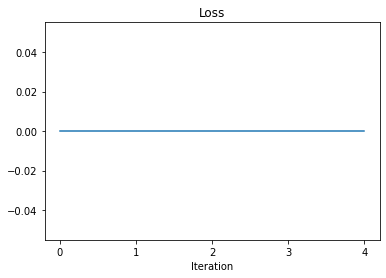

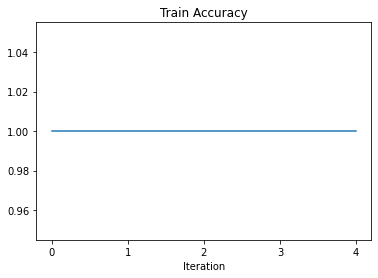

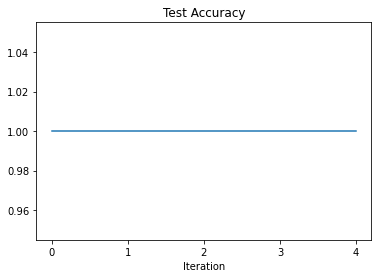

In [22]:
for title, data in {"Loss":train_loss,"Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}.items():
    plt.plot(data)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.xticks(range(training_iters))
    plt.show()